## Tested on:

{'qiskit-terra': '0.21.2', 'qiskit-aer': '0.11.0', 'qiskit-ignis': '0.2.0', 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.38.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': '0.4.0', 'qiskit-machine-learning': None}

In [1]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'
import qiskit
import glob
import os
import random
import math
#import pydot
from collections import defaultdict
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit import visualization
from itertools import permutations
from qiskit.providers.aer.noise import NoiseModel
from skquant.opt import minimize
%matplotlib inline
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit import IBMQ, Aer, transpile, schedule as build_schedule
from qiskit.tools.visualization import plot_histogram
from qiskit.test.mock import FakeParis
device_backend = FakeParis()

from skquant.opt import minimize

from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import RealAmplitudes
noise_model_backend = NoiseModel.from_backend(device_backend)
# Get coupling map from backend
coupling_map = device_backend.configuration().coupling_map
# Get basis gates from noise model
basis_gates = noise_model_backend.basis_gates
from qiskit.providers.aer.noise.device import thermal_relaxation_values

#We construct a noise model here for sim

#### IMPORTANT - we observe that decoherence mitigation is much more beneficial on the real device..
# than in simulation, due to simulator limitations how noise is modeled / mitigated
# therefore for simulation noise needs to be scaled up for observable results and can be used for sanity checks
#  real machine results (which ofc has no scaling etc) are the only things that really matter -
# all our results in the paper are from real machines
# 1q gate rescheduling is especially not seen to be useful in sim and needs to be real machine tested

#Converting this code to support real machine runs is non trivial since that will:
# a) either being able to perform the below within qiskit runtime (not possible in 2021) or
# b) running one iteration at a time on the real mahine which is slow
# plus (b) requires the below code to be broken into two parts, the first part creates the circuit and
# runs it on the machine, the 2nd part extracts results, performs compuations, and readies next iteration

thermal_relaxation_error = qiskit.providers.aer.noise.thermal_relaxation_error(t1=50, t2=60, time=0.35)
noise_model = qiskit.providers.aer.noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error, "id")  # during the delay, T1 and T2 will be in effect
noise_model_perQ = noise_model
sim_noise = qiskit.providers.aer.QasmSimulator(noise_model=noise_model)
sim_ideal = qiskit.providers.aer.QasmSimulator()
sim = Aer.get_backend('qasm_simulator') #Lets use this for all and only specify noise model etc separately - but not great for transpile?
def gen_ansatz(num_qubits=3,ansatz_type="SU2",entanglement="linear",reps=1):
    ansatz = QuantumCircuit(num_qubits)
    if(ansatz_type=="SU2"):
        ansatz = EfficientSU2(num_qubits=num_qubits, entanglement=entanglement,reps=reps)
    elif(ansatz_type=="RA"):
        ansatz = RealAmplitudes(num_qubits=num_qubits, entanglement=entanglement,reps=reps)
    else:
        return None
    return ansatz
def parity_ones(n):
    one_count=0
    for i in n:
        if i == "1":
            one_count+=1
    return one_count % 2
def calc(key_list,key,H,counts):
    for item in key_list:
        if (parity_ones(item)==0):
            H+=counts.get(key,0)
        else:
            H-=counts.get(key,0)
    return H

#This basically constructs an TFIM Hamiltonian of some limited sizes
def get_H_val(counts, counts_X, num_qubits, shots):
    H=0
    key_list_X = []
    key_list = []
    if(num_qubits == 2): # 2 qubit - XI + IX + ZZ
        for key in counts_X.keys():
            key_list_X = [key[0], key[1]]
            H=calc(key_list_X,key,H,counts_X)
        for key in counts.keys():
            key_list = [key]
            H=calc(key_list,key,H,counts)
    if(num_qubits == 3): # 3 qubit - XII + IXI + IIX + ZZI + IZZ + ZIZ
        for key in counts_X.keys():
            key_list_X = [key[0], key[1], key[2]]
            H=calc(key_list_X,key,H,counts_X)
        for key in counts.keys():
            key_list = [key[0:2], key[1:3], (key[0]+key[2])]
            H=calc(key_list,key,H,counts)
    if(num_qubits == 4): # 4 qubit - XIII + IXII + IIXI + IIIX + ZZII + IZZI +IIZZ + ZIIZ
        for key in counts_X.keys():
            key_list_X = [key[0],key[1],key[2],key[3]]
            H=calc(key_list_X,key,H,counts_X)
        for key in counts.keys():
            key_list = [key[0:2],key[1:3], key[2:4],(key[0]+key[3])]
            H=calc(key_list,key,H,counts)
    if(num_qubits == 5): # 5 qubit - XIIII + IXIII + IIXII + IIIXI + IIIIX + ZZIII + IZZII + IIZZI + IIIZZ + ZIIIZ
        for key in counts_X.keys():
            key_list_X = [key[0], key[1], key[2], key[3], key[4]]
            H=calc(key_list_X,key,H,counts_X)
        for key in counts.keys():
            key_list = [key[0:2],  key[1:3], key[2:4], key[3:5], (key[0]+key[4])]
            H=calc(key_list,key,H,counts)
    if(num_qubits == 6): # 6 qubit - XIIIII + IXIIII + IIXIII + IIIXII + IIIIXI + IIIIIX + ZZIIII + IZZIII + IIZZII + IIIZZI + IIIIZZ + ZIIIIZ
        for key in counts_X.keys():
            key_list_X = [key[0], key[1], key[2], key[3], key[4], key[5]]
            H=calc(key_list_X,key,H,counts_X)
        for key in counts.keys():
            key_list = [key[0:2], key[1:3], key[2:4], key[3:5], key[4:6], (key[0]+key[5])]
            H=calc(key_list,key,H,counts)
    if(num_qubits == 10): # 10 qubit
        for key in counts_X.keys():
            key_list_X = [key[0], key[1], key[2], key[3], key[4], key[5], key[6], key[7], key[8], key[9]]
            H=calc(key_list_X,key,H,counts_X)
        for key in counts.keys():
            key_list = [key[0:2], key[1:3], key[2:4], key[3:5], key[4:6], key[5:7], key[6:8], key[7:9], key[8:10], (key[0]+key[9])]
            H=calc(key_list,key,H,counts)
    H/=shots
#    print(H)
    return H

#This python file has all the mitigation technique related code:
from helpers_all_DD import *


sim_noise = qiskit.providers.aer.QasmSimulator(noise_model=noise_model,configuration=device_backend.configuration())
sim_noiseq = qiskit.providers.aer.QasmSimulator(noise_model=noise_model_perQ,configuration=device_backend.configuration())
sim_ideal = qiskit.providers.aer.QasmSimulator(configuration=device_backend.configuration())

/var/folders/69/sd9gl1fs63lf3p5xv59g6q4m0000gn/T/ipykernel_77323/3218371822.py:34: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeParis
/Users/aaronspears/Documents/2024Spring/CPSC8810/ProjectCode/.venv/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (78724.73839768364 > 2 * 17977.586136949183). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/Users/aaronspears/Documents/2024Spring/CPSC8810/ProjectCode/.venv/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 

In [2]:

####VAQEM + mitigation technique####

# 60 angle params + 60 migitation params... 
#angle params is directly from ansatz - so should be accurate, 
#mitigation params can be profiled from the circit but can be set to any number - 
#larger means more mitigation potential but harder for the tuner
#location is returned between 0 and 10 to keep range similar to angle. it is divided by 10 later.

ANGLE_PARAMS=60
MITIG_PARAMS=60

bounds_array=[]
initial_array=[]

for i in range(ANGLE_PARAMS):
    bounds_array.append([0, np.pi*2])
    initial_array.append(np.pi)
for i in range(MITIG_PARAMS):
    bounds_array.append([0, 10])
    initial_array.append(0)
    
bounds=np.array(bounds_array)
initial_point=np.array(initial_array)
#bounds=[(0, np.pi*2)]*100
#initial_point=[np.pi]*100
gradient_fn=None
cost_array_noiseperQ_slack=[]
##### 6 qubits ####
NUM_QUBITS=6
ansatz = gen_ansatz(num_qubits=NUM_QUBITS,ansatz_type="SU2",entanglement="linear",reps=4)
print(ansatz.num_parameters)
nparams=ansatz.num_parameters
tp_array = []
def run_and_eval(params, num_qubits=NUM_QUBITS, shots=8192,cost_arr=cost_array_noiseperQ_slack):
    #print(num_qubits)
    tp_array.append(params)
    
    #Our Hamiltonians have Z^I terms  or X^I terms, so we need two circuits
    #Qiskit now has some vqe modules which can automate all of this 
    ansatz = gen_ansatz(num_qubits=NUM_QUBITS,ansatz_type="SU2",entanglement="linear",reps=4)
    param_ansatz = ansatz.assign_parameters(params[:nparams])
    #print(ansatz.num_parameters)
    qc=QuantumCircuit(num_qubits)
    qc.h(range(num_qubits))
    param_ansatz_X = param_ansatz + qc
    new_creg = param_ansatz._create_creg(len(param_ansatz.qubits), 'c')
    param_ansatz.add_register(new_creg)
    param_ansatz.measure(param_ansatz.qubits, new_creg)
    new_creg = param_ansatz_X._create_creg(len(param_ansatz_X.qubits), 'c')
    param_ansatz_X.add_register(new_creg)
    param_ansatz_X.measure(param_ansatz_X.qubits, new_creg)
    param_ansatz = transpile(param_ansatz,sim_noiseq,basis_gates=noise_model_perQ.basis_gates,optimization_level=3,seed_transpiler=0)
    param_ansatz_X = transpile(param_ansatz_X,sim_noiseq,basis_gates=noise_model_perQ.basis_gates,optimization_level=3,seed_transpiler=0)
    
    vec = [0]*1000
    for i in range(MITIG_PARAMS):
        vec[i] = params[nparams+i]/10.0
        if(vec[i]<0):
            vec[i]=0
        if(vec[i]>1):
            vec[i]=1
    #print(params)
    
    #The below is focused on dynamic decoupling, where the tunable parameter 
    # is tuning the number of DD sequences inserted in the idle windows
    #Inserted sequences are spaced out as a periodic distribution.
    param_ansatz,_=return_adj_sched_circuit_dd(param_ansatz,backend=device_backend,use_dd_padding=True,dd_style='full',location=0,fixed_placement = True,rounds=vec,spread=1,seq='xy')
    param_ansatz_X,_=return_adj_sched_circuit_dd(param_ansatz_X,backend=device_backend,use_dd_padding=True,dd_style='full',location=0,fixed_placement = True,rounds=vec,spread=1,seq='xy')

    #Another option is single-qubit gate scheduling by tuning the gate positions in idle windows:
    #param_ansatz,_=return_adj_sched_circuit(param_ansatz, backend=device_backend,location = 0, use_padding=True, fixed_placement = False,DELAY_VECT = vec)
    #param_ansatz_X,_=return_adj_sched_circuit(param_ansatz_X, backend=device_backend,location = 0, use_padding=True, fixed_placement = False,DELAY_VECT = vec)
    
    #In this code we run in simulation. If this was real machine, here you would launch on real device
    #You would then save the job id and once jobs complete you can proceed by retrieving results
    counts = sim_noiseq.run(param_ansatz, shots=8192).result().get_counts()
    counts_X = sim_noiseq.run(param_ansatz_X, shots=8192).result().get_counts()
    
    cost = get_H_val(counts=counts, counts_X=counts_X, num_qubits=num_qubits, shots=shots)
    cost_arr.append(cost)
    return cost
cost_fn=run_and_eval
budget = 1000

#We use optimizers from skquant which has to be installed
#qiskit defaults like spsa can also be used but they are painfully slow
from skquant.opt import minimize
# 5. method can be ImFil, SnobFit, NOMAD, Orbit, or Bobyqa (case insensitive)
result, history = minimize(cost_fn, initial_point, bounds, budget, method='Imfil')



####baseline####

bounds_array=[]
initial_array=[]

for i in range(ANGLE_PARAMS):
    bounds_array.append([0, np.pi*2])
    initial_array.append(np.pi)

bounds=np.array(bounds_array)
initial_point=np.array(initial_array)
gradient_fn=None
cost_array_noiseperQ_noslack=[]
##### 6 qubits ####
NUM_QUBITS=6
ansatz = gen_ansatz(num_qubits=NUM_QUBITS,ansatz_type="SU2",entanglement="linear",reps=4)
print(ansatz.num_parameters)
nparams=ansatz.num_parameters
tp_array_v2 = []
def run_and_eval(params, num_qubits=NUM_QUBITS, shots=8192,cost_arr=cost_array_noiseperQ_noslack):
    #print(num_qubits)
    tp_array_v2.append(params)
    ansatz = gen_ansatz(num_qubits=NUM_QUBITS,ansatz_type="SU2",entanglement="linear",reps=4)
    param_ansatz = ansatz.assign_parameters(params)
    #print(ansatz.num_parameters)
    nparams=ansatz.num_parameters
    qc=QuantumCircuit(num_qubits)
    qc.h(range(num_qubits))
    param_ansatz_X = param_ansatz + qc

    new_creg = param_ansatz._create_creg(len(param_ansatz.qubits), 'c')
    param_ansatz.add_register(new_creg)
    param_ansatz.measure(param_ansatz.qubits, new_creg)
    new_creg = param_ansatz_X._create_creg(len(param_ansatz_X.qubits), 'c')
    param_ansatz_X.add_register(new_creg)
    param_ansatz_X.measure(param_ansatz_X.qubits, new_creg)
    param_ansatz = transpile(param_ansatz,sim_noiseq,basis_gates=noise_model_perQ.basis_gates,optimization_level=3,seed_transpiler=0)
    param_ansatz_X = transpile(param_ansatz_X,sim_noiseq,basis_gates=noise_model_perQ.basis_gates,optimization_level=3,seed_transpiler=0)    
    
    param_ansatz,_=return_adj_sched_circuit(param_ansatz, backend=device_backend,location = 0, use_padding=True)
    param_ansatz_X,_=return_adj_sched_circuit(param_ansatz_X, backend=device_backend,location = 0, use_padding=True)
    counts = sim_noiseq.run(param_ansatz, shots=8192).result().get_counts()
    counts_X = sim_noiseq.run(param_ansatz_X, shots=8192).result().get_counts()
    
    cost = get_H_val(counts=counts, counts_X=counts_X, num_qubits=num_qubits, shots=shots)
    #print("Cost:",cost)
    cost_arr.append(cost)
    return cost
cost_fn=run_and_eval

# 4. budget (number of calls, assuming 1 count per call)
budget = 1000
from skquant.opt import minimize
# 5. method can be ImFil, SnobFit, NOMAD, Orbit, or Bobyqa (case insensitive)
result, history = minimize(cost_fn, initial_point, bounds, budget, method='Imfil')

/var/folders/69/sd9gl1fs63lf3p5xv59g6q4m0000gn/T/ipykernel_77323/679021417.py:45: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  param_ansatz_X = param_ansatz + qc


108


/var/folders/69/sd9gl1fs63lf3p5xv59g6q4m0000gn/T/ipykernel_77323/679021417.py:45: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  param_ansatz_X = param_ansatz + qc


108


ValueError: Mismatching number of values and parameters. For partial binding please pass a dictionary of {parameter: value} pairs.

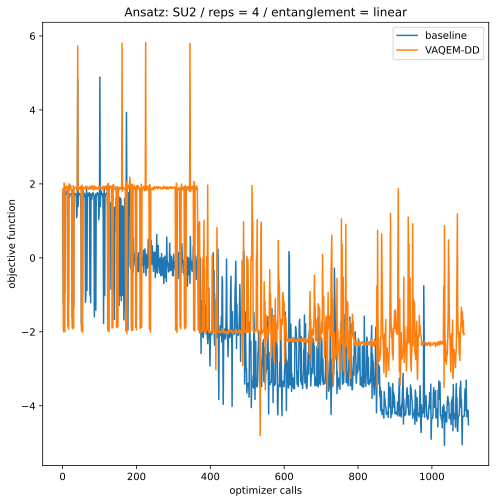

In [ ]:
itnq = np.linspace(1,  len(cost_array_noiseperQ_noslack), len(cost_array_noiseperQ_noslack), dtype=int)
itnqs = np.linspace(1,  len(cost_array_noiseperQ_slack), len(cost_array_noiseperQ_slack), dtype=int)
f=plt.figure(figsize=(8, 8), dpi=80)
plt.plot(itnq, cost_array_noiseperQ_noslack,label='baseline')
plt.plot(itnqs, cost_array_noiseperQ_slack,label='VAQEM-DD')
plt.title("Ansatz: SU2 / reps = 8 / entanglement = full")
plt.xlabel('optimizer calls')
plt.ylabel('objective function')
plt.legend()

In [ ]:
qiskit.__qiskit_version__


{'qiskit-terra': '0.21.2', 'qiskit-aer': '0.11.0', 'qiskit-ignis': '0.2.0', 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.38.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}